In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

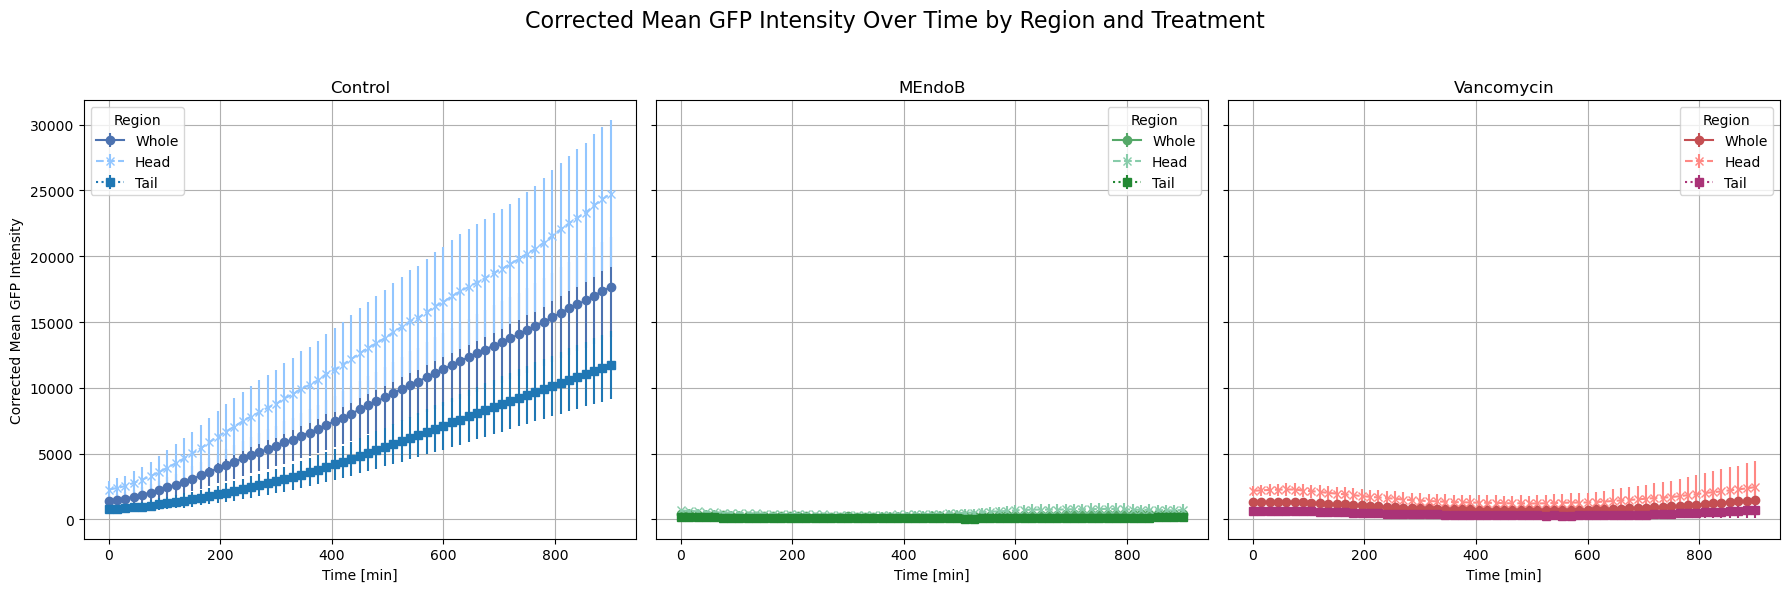

In [2]:
# Load the CSV file
file_path = "./gfp_intensity_results_vit_l.csv"
df = pd.read_csv(file_path)

# --- Data Preprocessing ---
# Extract group and treatment information
df['Group'] = df['Identifier'].str.extract(r'([A-D])')[0]
df['Treatment'] = df['Group'].map({'A': 'MEndoB', 'B': 'Vancomycin', 'C': 'Control', 'D': 'Blank'})
df['Time'] = (df['Identifier'].str.extract(r'_(\d+)$').astype(int)-1) * 15

# Calculate the mean intensity of the blank wells (D4-D6) for each time point
blank_summary = (
    df[df['Treatment'] == 'Blank']
    .groupby('Time')
    .agg(
        Blank_Mean_GFP_Intensity=('Mean_GFP_Intensity', 'mean'),
        Blank_Mean_Total_Intensity=('Total_GFP_Intensity', 'mean'),
        Blank_Mean_Head_Intensity=('Mean_GFP_Head', 'mean'),
        Blank_Mean_Tail_Intensity=('Mean_GFP_Tail', 'mean')
    )
    .reset_index()
)

# Merge the blank summary with the original data for noise correction
df = pd.merge(df, blank_summary, on='Time', how='left')

# Apply noise correction
df['Corrected_Mean_GFP_Intensity'] = df['Mean_GFP_Intensity'] - df['Blank_Mean_GFP_Intensity']
df['Corrected_Total_GFP_Intensity'] = df['Total_GFP_Intensity'] - df['Blank_Mean_Total_Intensity']
df['Corrected_Mean_Head_Intensity'] = df['Mean_GFP_Head'] - df['Blank_Mean_Head_Intensity']
df['Corrected_Total_Head_Intensity'] = df['Total_GFP_Head'] - df['Blank_Mean_Head_Intensity']
df['Corrected_Mean_Tail_Intensity'] = df['Mean_GFP_Tail'] - df['Blank_Mean_Tail_Intensity']
df['Corrected_Total_Tail_Intensity'] = df['Total_GFP_Tail'] - df['Blank_Mean_Tail_Intensity']

# Filter out the blank wells for further analysis
df = df[df['Treatment'] != 'Blank']

# Group by Treatment and Time to calculate mean and standard error for the line plot
summary = df.groupby(['Treatment', 'Time']).agg(
    Whole_Mean=('Corrected_Mean_GFP_Intensity', 'mean'),
    Whole_SEM=('Corrected_Mean_GFP_Intensity', 'sem'),
    Head_Mean=('Corrected_Mean_Head_Intensity', 'mean'),
    Head_SEM=('Corrected_Mean_Head_Intensity', 'sem'),
    Tail_Mean=('Corrected_Mean_Tail_Intensity', 'mean'),
    Tail_SEM=('Corrected_Mean_Tail_Intensity', 'sem'),
).reset_index()

# Define a custom color palette for better understanding
colors = {
    'Control': ['#4C72B0', '#92C6FF', '#1F77B4'],  # Shades of blue
    'MEndoB': ['#55A868', '#88CCAA', '#228833'],   # Shades of green
    'Vancomycin': ['#C44E52', '#FF8884', '#AA3377']  # Shades of red
}

# --- Line Plot for Mean GFP Intensities (Subplots) ---
treatments = summary['Treatment'].unique()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)

for ax, treatment in zip(axes, treatments):
    subset = summary[summary['Treatment'] == treatment]
    
    # Plot each region
    ax.errorbar(subset['Time'], subset['Whole_Mean'], yerr=subset['Whole_SEM'], 
                label="Whole", linestyle='-', marker='o', color=colors[treatment][0])
    ax.errorbar(subset['Time'], subset['Head_Mean'], yerr=subset['Head_SEM'], 
                label="Head", linestyle='--', marker='x', color=colors[treatment][1])
    ax.errorbar(subset['Time'], subset['Tail_Mean'], yerr=subset['Tail_SEM'], 
                label="Tail", linestyle=':', marker='s', color=colors[treatment][2])
    
    # Set axis labels, grid, and title
    ax.set_title(treatment)
    ax.set_xlabel("Time [min]")
    ax.grid()
    
    # Add a legend for each subplot
    ax.legend(title="Region")

# Add shared y-axis label
axes[0].set_ylabel("Corrected Mean GFP Intensity")

# Add a shared title and adjust layout
fig.suptitle("Corrected Mean GFP Intensity Over Time by Region and Treatment", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

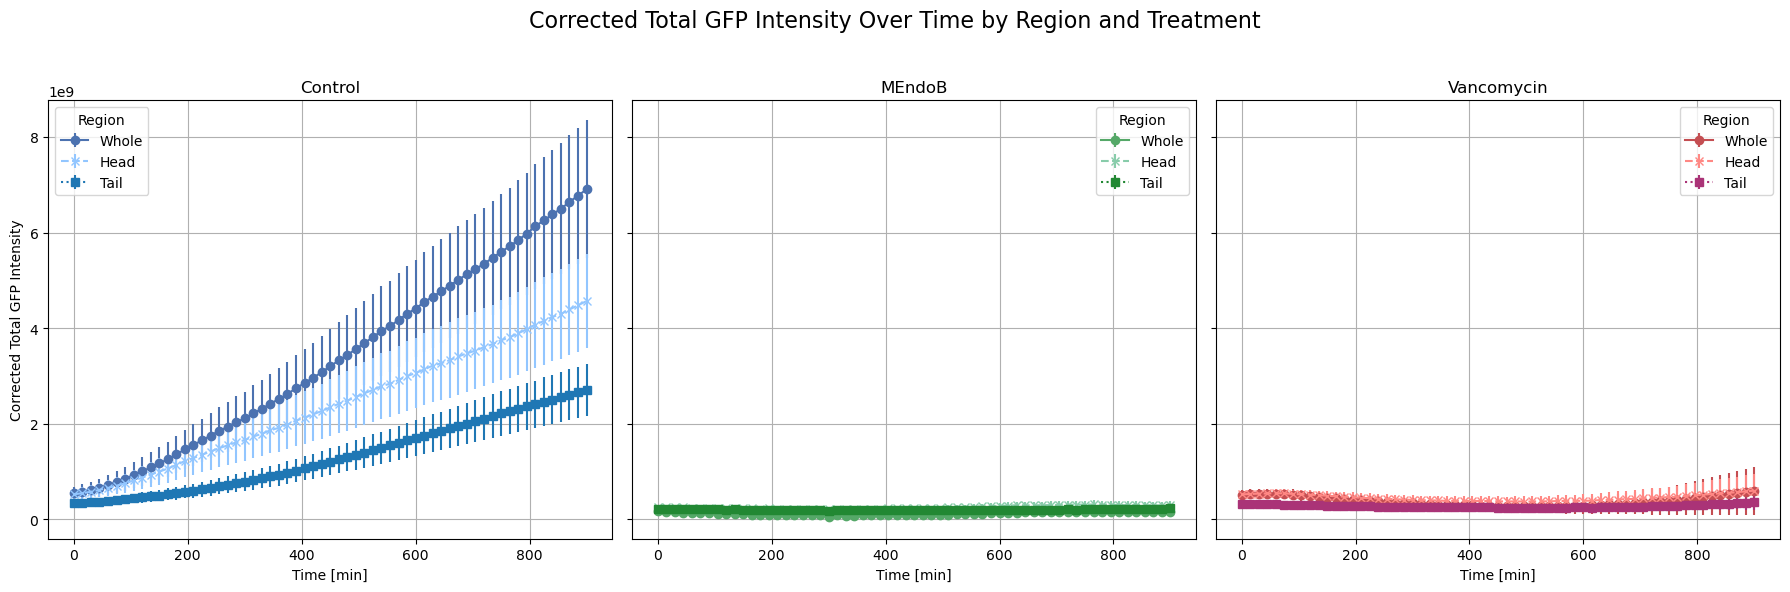

In [3]:
# --- Line Plot for Corrected Total GFP Intensities (Head, Tail, Whole Fish) ---
# Group by Treatment and Time for total GFP intensity
summary_total = df.groupby(['Treatment', 'Time']).agg(
    Whole_Total=('Corrected_Total_GFP_Intensity', 'mean'),
    Whole_SEM=('Corrected_Total_GFP_Intensity', 'sem'),
    Head_Total=('Corrected_Total_Head_Intensity', 'mean'),
    Head_SEM=('Corrected_Total_Head_Intensity', 'sem'),
    Tail_Total=('Corrected_Total_Tail_Intensity', 'mean'),
    Tail_SEM=('Corrected_Total_Tail_Intensity', 'sem'),
).reset_index()

# --- Line Plot for Total GFP Intensities (Subplots with Legends) ---
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)

for ax, treatment in zip(axes, treatments):
    subset = summary_total[summary_total['Treatment'] == treatment]
    
    # Plot each region
    ax.errorbar(subset['Time'], subset['Whole_Total'], yerr=subset['Whole_SEM'], 
                label="Whole", linestyle='-', marker='o', color=colors[treatment][0])
    ax.errorbar(subset['Time'], subset['Head_Total'], yerr=subset['Head_SEM'], 
                label="Head", linestyle='--', marker='x', color=colors[treatment][1])
    ax.errorbar(subset['Time'], subset['Tail_Total'], yerr=subset['Tail_SEM'], 
                label="Tail", linestyle=':', marker='s', color=colors[treatment][2])
    
    # Set axis labels, grid, and title
    ax.set_title(treatment)
    ax.set_xlabel("Time [min]")
    ax.grid()
    
    # Add a legend for each subplot
    ax.legend(title="Region")

# Add shared y-axis label
axes[0].set_ylabel("Corrected Total GFP Intensity")

# Add a shared title and adjust layout
fig.suptitle("Corrected Total GFP Intensity Over Time by Region and Treatment", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


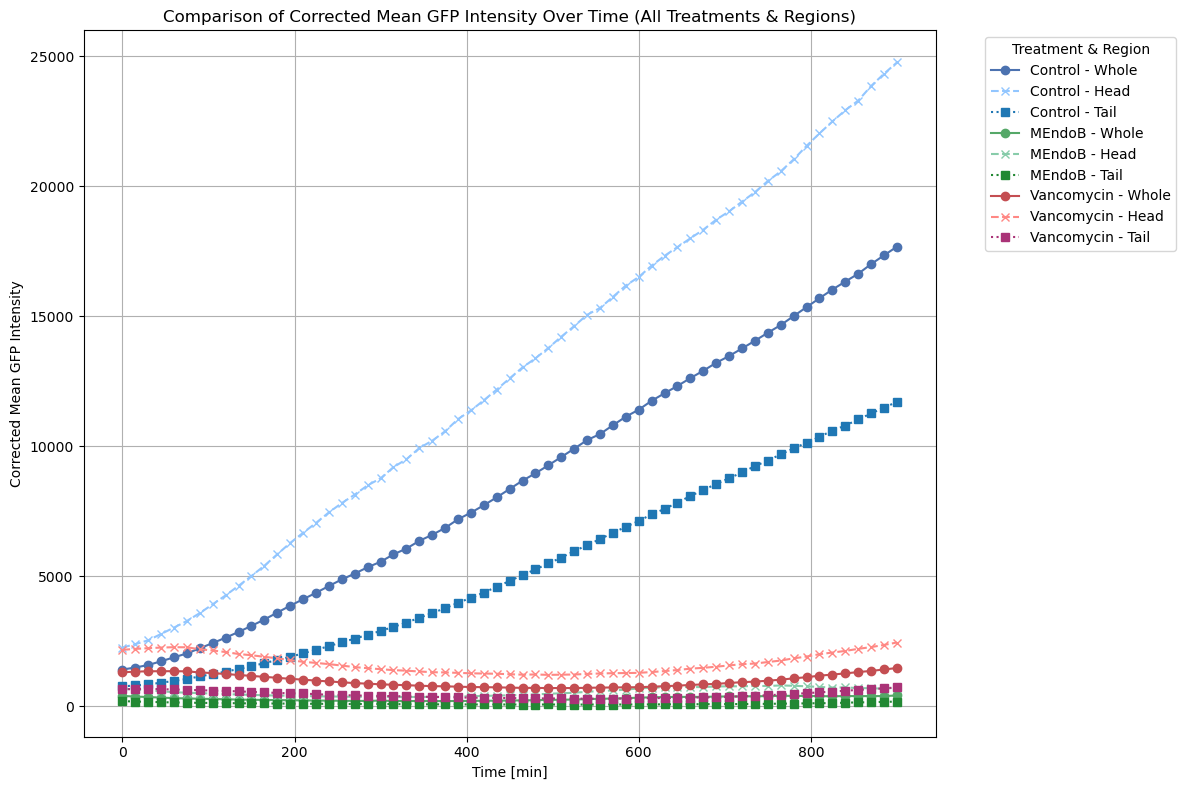

In [4]:
# --- Simple Line Plot for All Treatments and Regions ---
plt.figure(figsize=(12, 8))

for treatment in summary['Treatment'].unique():
    subset = summary[summary['Treatment'] == treatment]
    plt.plot(
        subset['Time'], subset['Whole_Mean'], 
        label=f"{treatment} - Whole", linestyle='-', marker='o', color=colors[treatment][0]
    )
    plt.plot(
        subset['Time'], subset['Head_Mean'], 
        label=f"{treatment} - Head", linestyle='--', marker='x', color=colors[treatment][1]
    )
    plt.plot(
        subset['Time'], subset['Tail_Mean'], 
        label=f"{treatment} - Tail", linestyle=':', marker='s', color=colors[treatment][2]
    )

# Add labels, legend, and title
plt.xlabel("Time [min]")
plt.ylabel("Corrected Mean GFP Intensity")
plt.title("Comparison of Corrected Mean GFP Intensity Over Time (All Treatments & Regions)")
plt.legend(title="Treatment & Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()


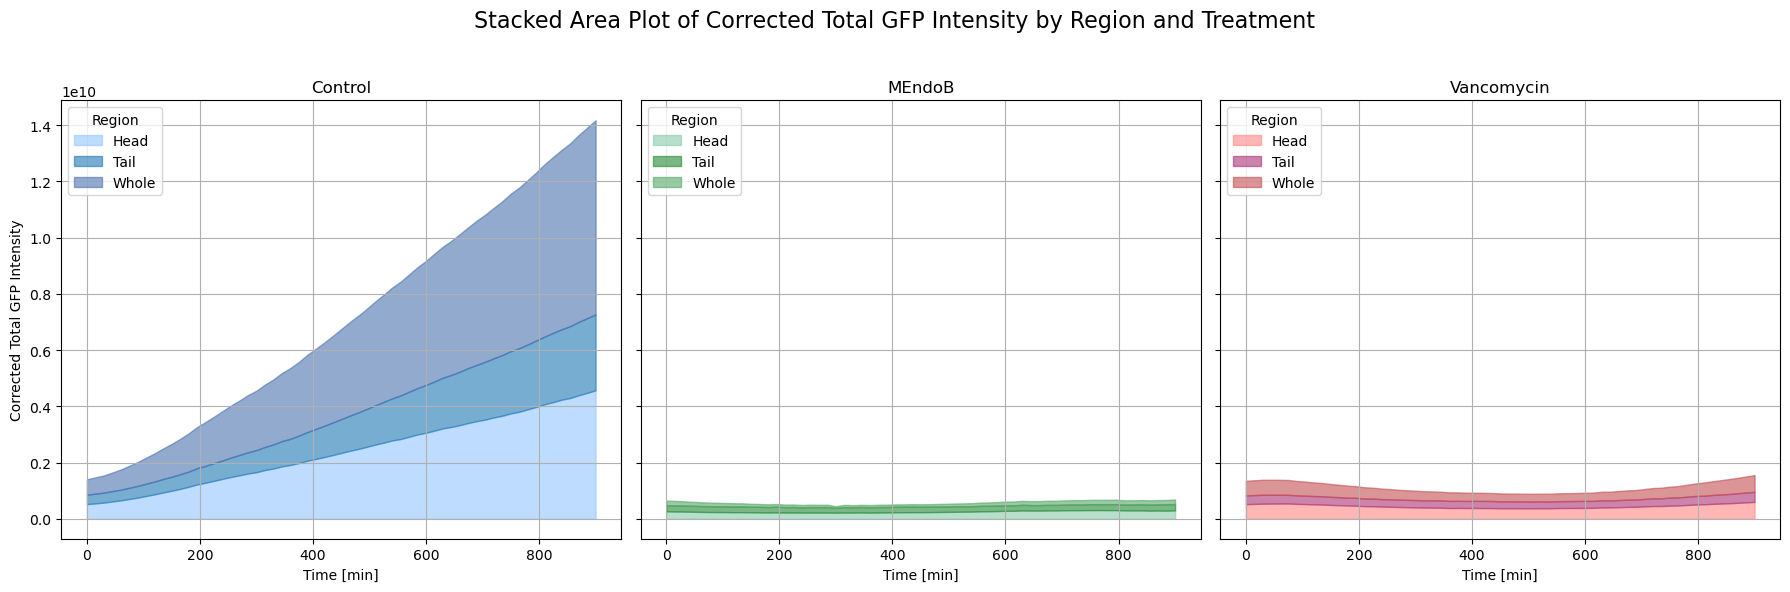

In [5]:
# --- Stacked Area Plot for Corrected Total GFP Intensity ---
# Group by Treatment and Time for total GFP intensity
summary_total = df.groupby(['Treatment', 'Time']).agg(
    Whole_Total=('Corrected_Total_GFP_Intensity', 'mean'),
    Head_Total=('Corrected_Total_Head_Intensity', 'mean'),
    Tail_Total=('Corrected_Total_Tail_Intensity', 'mean')
).reset_index()

# Define the custom color palette
# area_colors = {
#     'Control': ['#1F77B4', '#4C72B0', '#92C6FF'],  # Shades of blue
#     'MEndoB': ['#228833', '#55A868', '#88CCAA'],  # Shades of green
#     'Vancomycin': ['#AA3377', '#C44E52', '#FF8884']  # Shades of red
# }

# --- Stacked Area Plot for Total GFP Intensities (Subplots) ---
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)

for ax, treatment in zip(axes, treatments):
    subset = summary_total[summary_total['Treatment'] == treatment]

    # Ensure stacking order: Head + Tail + Whole
    total_sum = subset['Head_Total'] + subset['Tail_Total']
    ax.fill_between(
        subset['Time'], 0, subset['Head_Total'], 
        color=colors[treatment][1], alpha=0.6, label="Head"
    )
    ax.fill_between(
        subset['Time'], subset['Head_Total'], total_sum, 
        color=colors[treatment][2], alpha=0.6, label="Tail"
    )
    ax.fill_between(
        subset['Time'], total_sum, total_sum + subset['Whole_Total'], 
        color=colors[treatment][0], alpha=0.6, label="Whole"
    )

    # Titles and grid
    ax.set_title(treatment)
    ax.set_xlabel("Time [min]")
    ax.grid()

    # Add legend for each plot
    ax.legend(title="Region", loc="upper left")

# Common y-axis label and title
axes[0].set_ylabel("Corrected Total GFP Intensity")
fig.suptitle("Stacked Area Plot of Corrected Total GFP Intensity by Region and Treatment", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()




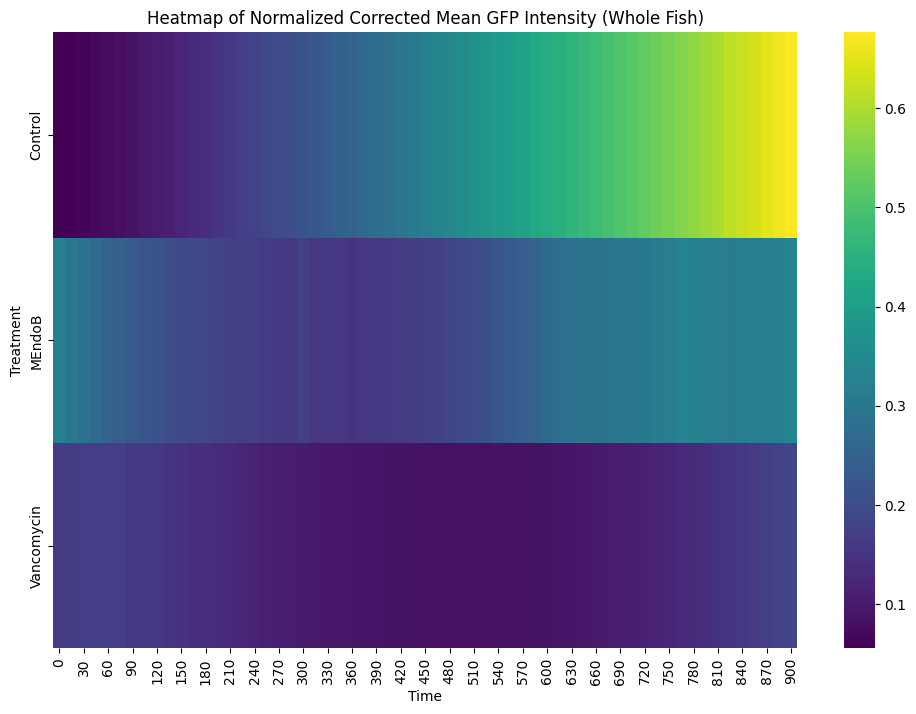

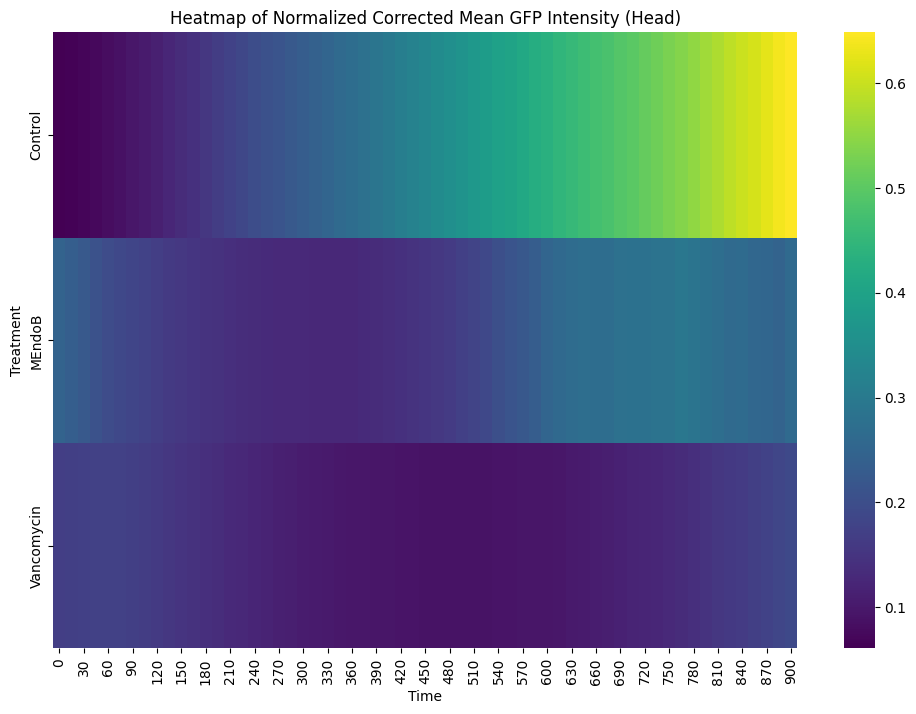

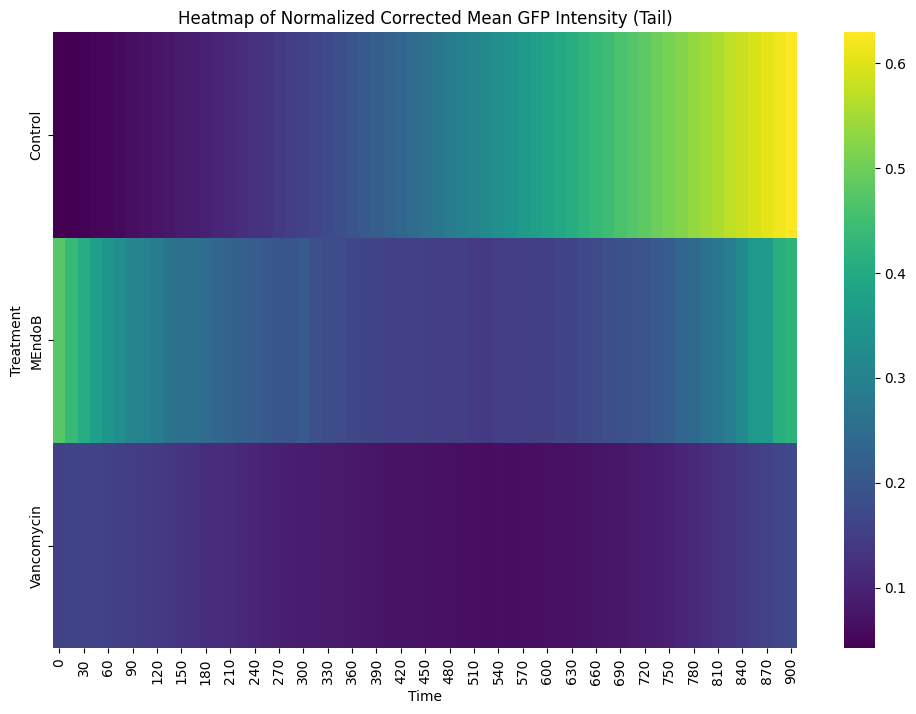

In [6]:
# --- Heatmap of Normalized Corrected Mean GFP Intensities ---
# Normalize intensities within each region
df['Normalized_Whole_Mean'] = df.groupby('Treatment')['Corrected_Mean_GFP_Intensity'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['Normalized_Head_Mean'] = df.groupby('Treatment')['Corrected_Mean_Head_Intensity'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['Normalized_Tail_Mean'] = df.groupby('Treatment')['Corrected_Mean_Tail_Intensity'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# Pivot for heatmap
heatmap_data = df.pivot_table(index='Treatment', columns='Time', values='Normalized_Whole_Mean', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=False)
plt.title("Heatmap of Normalized Corrected Mean GFP Intensity (Whole Fish)")
plt.show()

# Separate heatmaps for head and tail
for region, column in [('Head', 'Normalized_Head_Mean'), ('Tail', 'Normalized_Tail_Mean')]:
    heatmap_data = df.pivot_table(index='Treatment', columns='Time', values=column, aggfunc='mean')
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, cmap='viridis', annot=False)
    plt.title(f"Heatmap of Normalized Corrected Mean GFP Intensity ({region})")
    plt.show()

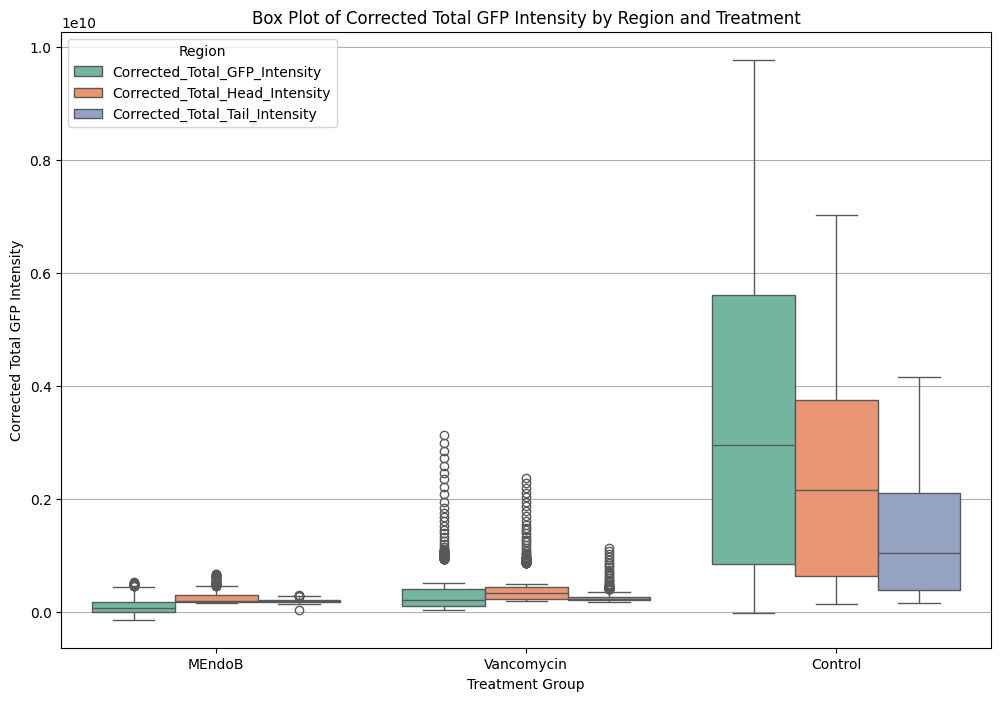

In [7]:
# --- Box Plot for Corrected Total GFP Intensity (Head, Tail, Whole Fish) ---
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df.melt(
        id_vars=['Treatment'],
        value_vars=[
            'Corrected_Total_GFP_Intensity', 'Corrected_Total_Head_Intensity', 'Corrected_Total_Tail_Intensity'
        ],
        var_name='Region',
        value_name='Corrected GFP Intensity'
    ),
    x='Treatment', y='Corrected GFP Intensity', hue='Region', palette='Set2', showfliers=True
)
plt.xlabel("Treatment Group")
plt.ylabel("Corrected Total GFP Intensity")
plt.title("Box Plot of Corrected Total GFP Intensity by Region and Treatment")
plt.grid(axis='y')
plt.legend(title="Region")
plt.show()

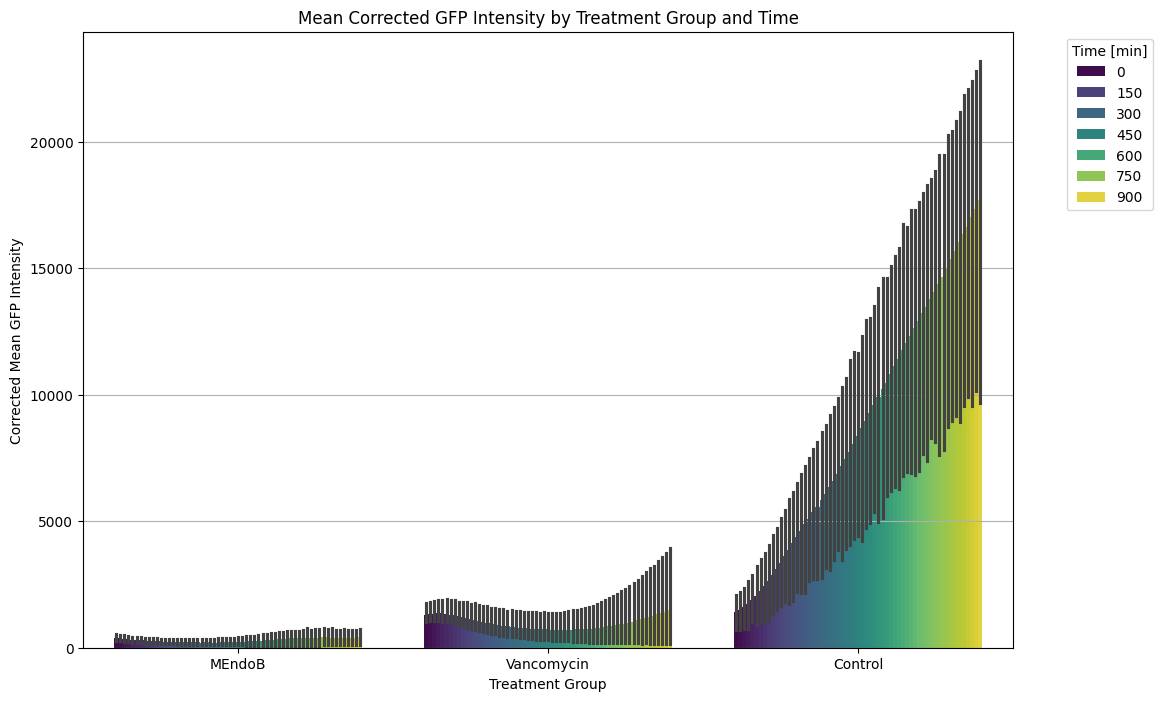

In [10]:
# Create grouped barchart for mean GFP intensity
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='Treatment', y='Corrected_Mean_GFP_Intensity', hue='Time', palette='viridis')
plt.xlabel("Treatment Group")
plt.ylabel("Corrected Mean GFP Intensity")
plt.title("Mean Corrected GFP Intensity by Treatment Group and Time")
plt.grid(axis='y')
plt.legend(title="Time [min]", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


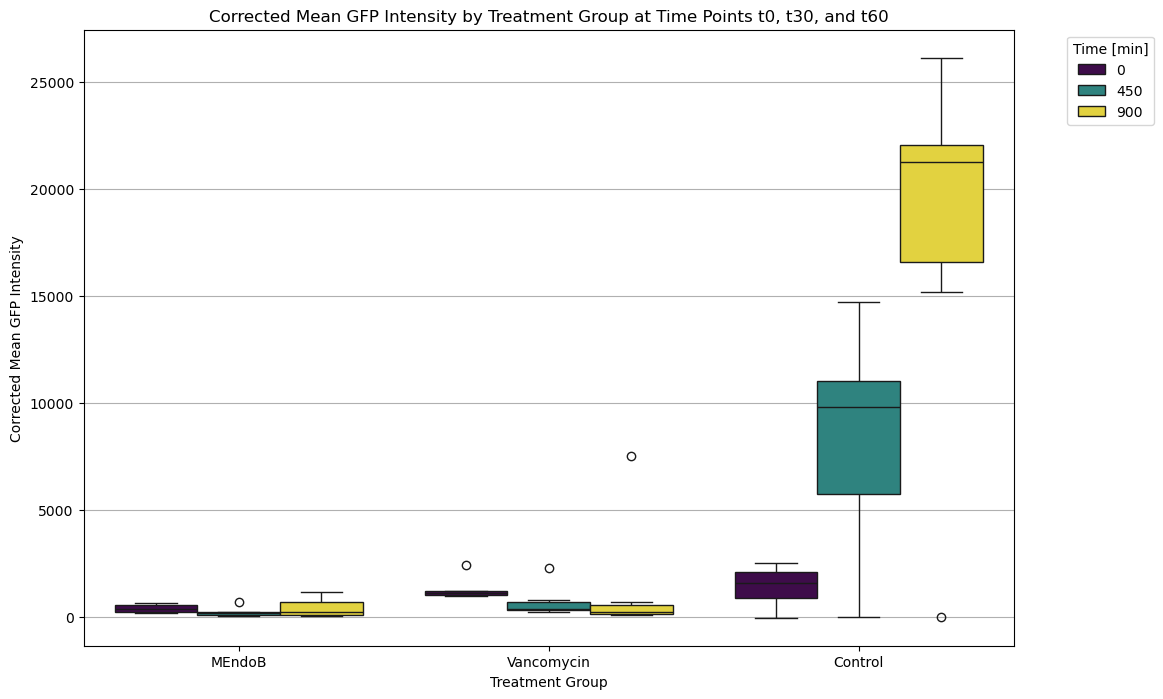

In [6]:
# Create boxplot for corrected mean GFP intensity by treatment group for time points t0, t30 and t60
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[df['Time'].isin([0, 450, 900])], x='Treatment', y='Corrected_Mean_GFP_Intensity', hue='Time', palette='viridis')
plt.xlabel("Treatment Group")
plt.ylabel("Corrected Mean GFP Intensity")
plt.title("Corrected Mean GFP Intensity by Treatment Group at Time Points t0, t30, and t60")
plt.grid(axis='y')
plt.legend(title="Time [min]", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

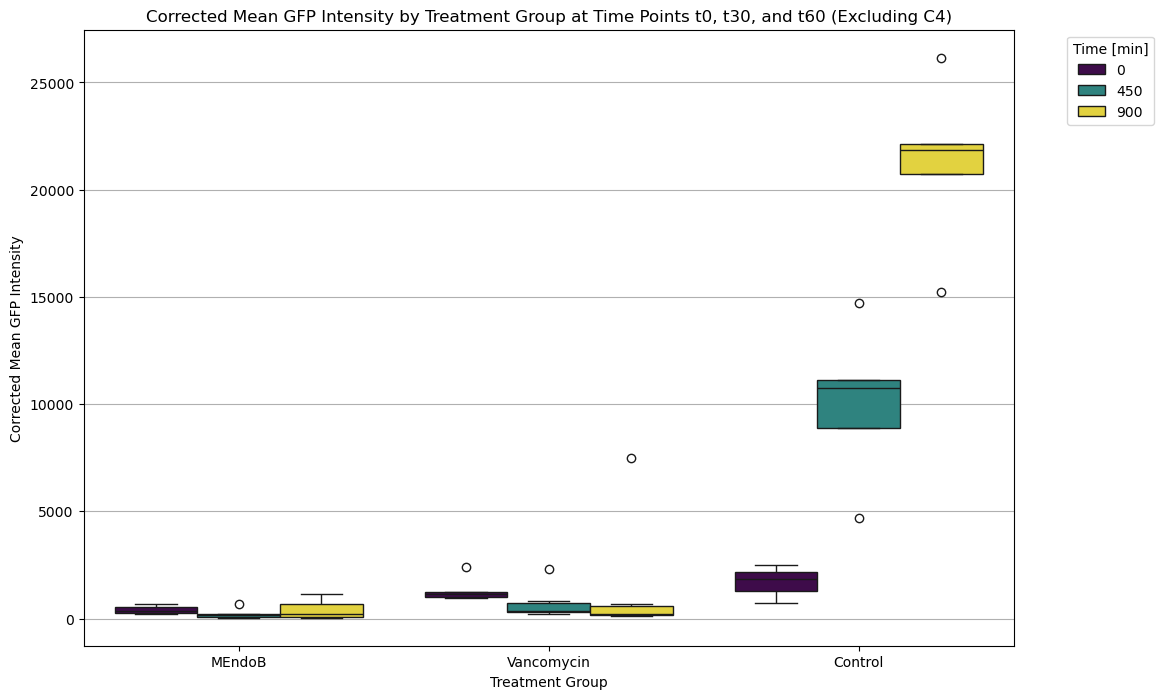

In [7]:
# Create boxplot for corrected mean GFP intensity by treatment group for time points t0, t30 and t60 but exclude identifier that starts with C4
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[(df['Time'].isin([0, 450, 900])) & (~df['Identifier'].str.startswith('C4'))], x='Treatment', y='Corrected_Mean_GFP_Intensity', hue='Time', palette='viridis')
plt.xlabel("Treatment Group")
plt.ylabel("Corrected Mean GFP Intensity")
plt.title("Corrected Mean GFP Intensity by Treatment Group at Time Points t0, t30, and t60 (Excluding C4)")
plt.grid(axis='y')
plt.legend(title="Time [min]", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


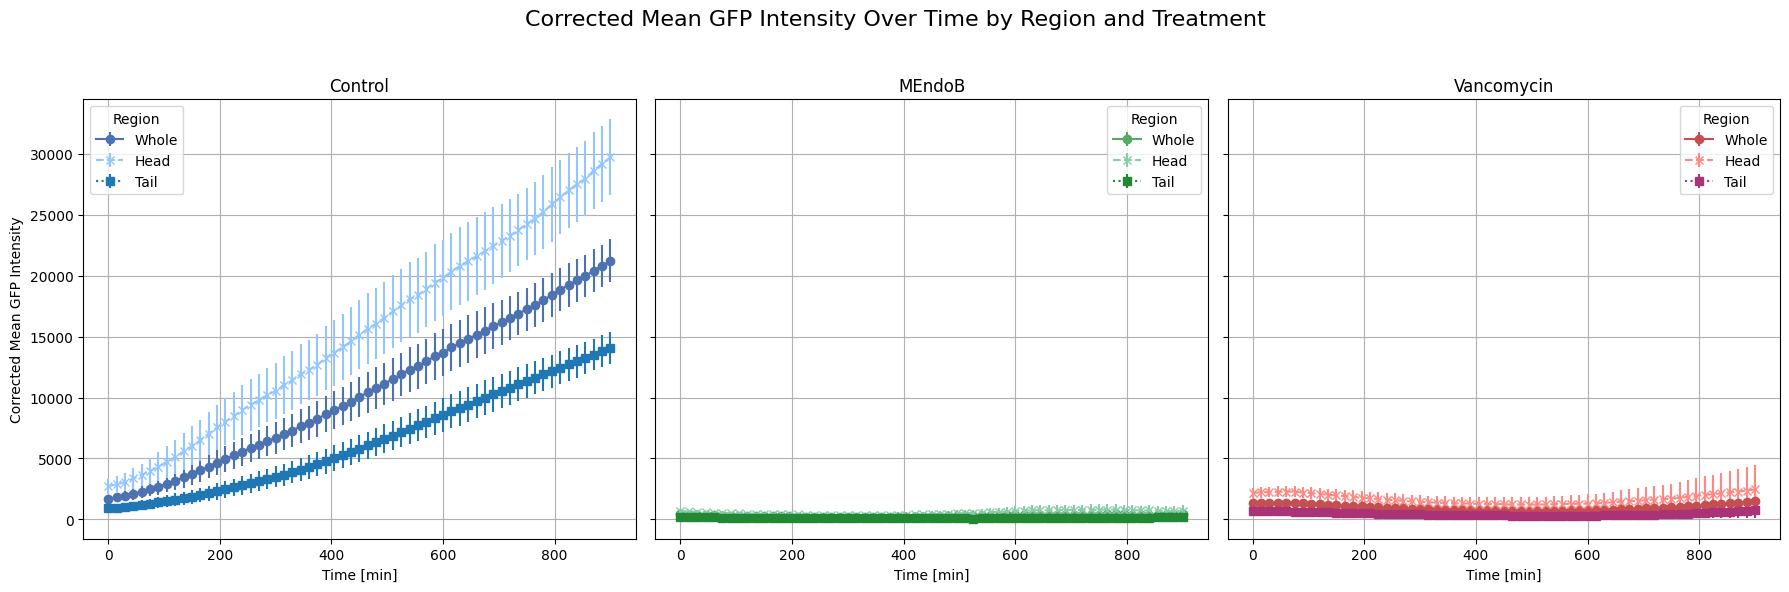

In [29]:
# Exclude identifier that starts with C4
filtered_df = df[~df['Identifier'].str.startswith('C4')]

# Group by Treatment and Time to calculate mean and standard error for the line plot
summary = filtered_df.groupby(['Treatment', 'Time']).agg(
    Whole_Mean=('Corrected_Mean_GFP_Intensity', 'mean'),
    Whole_SEM=('Corrected_Mean_GFP_Intensity', 'sem'),
    Head_Mean=('Corrected_Mean_Head_Intensity', 'mean'),
    Head_SEM=('Corrected_Mean_Head_Intensity', 'sem'),
    Tail_Mean=('Corrected_Mean_Tail_Intensity', 'mean'),
    Tail_SEM=('Corrected_Mean_Tail_Intensity', 'sem'),
).reset_index()

# Generate lineplot for corrected mean GFP intensity by treatment group, excluding identifier that starts with C4
treatments = summary['Treatment'].unique()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)

for ax, treatment in zip(axes, treatments):
    subset = summary[summary['Treatment'] == treatment]
    
    # Plot each region
    ax.errorbar(subset['Time'], subset['Whole_Mean'], yerr=subset['Whole_SEM'], 
                label="Whole", linestyle='-', marker='o', color=colors[treatment][0])
    ax.errorbar(subset['Time'], subset['Head_Mean'], yerr=subset['Head_SEM'], 
                label="Head", linestyle='--', marker='x', color=colors[treatment][1])
    ax.errorbar(subset['Time'], subset['Tail_Mean'], yerr=subset['Tail_SEM'], 
                label="Tail", linestyle=':', marker='s', color=colors[treatment][2])
    
    # Set axis labels, grid, and title
    ax.set_title(treatment)
    ax.set_xlabel("Time [min]")
    ax.grid()
    
    # Add a legend for each subplot
    ax.legend(title="Region")

# Add shared y-axis label
axes[0].set_ylabel("Corrected Mean GFP Intensity")

# Add a shared title and adjust layout
fig.suptitle("Corrected Mean GFP Intensity Over Time by Region and Treatment", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

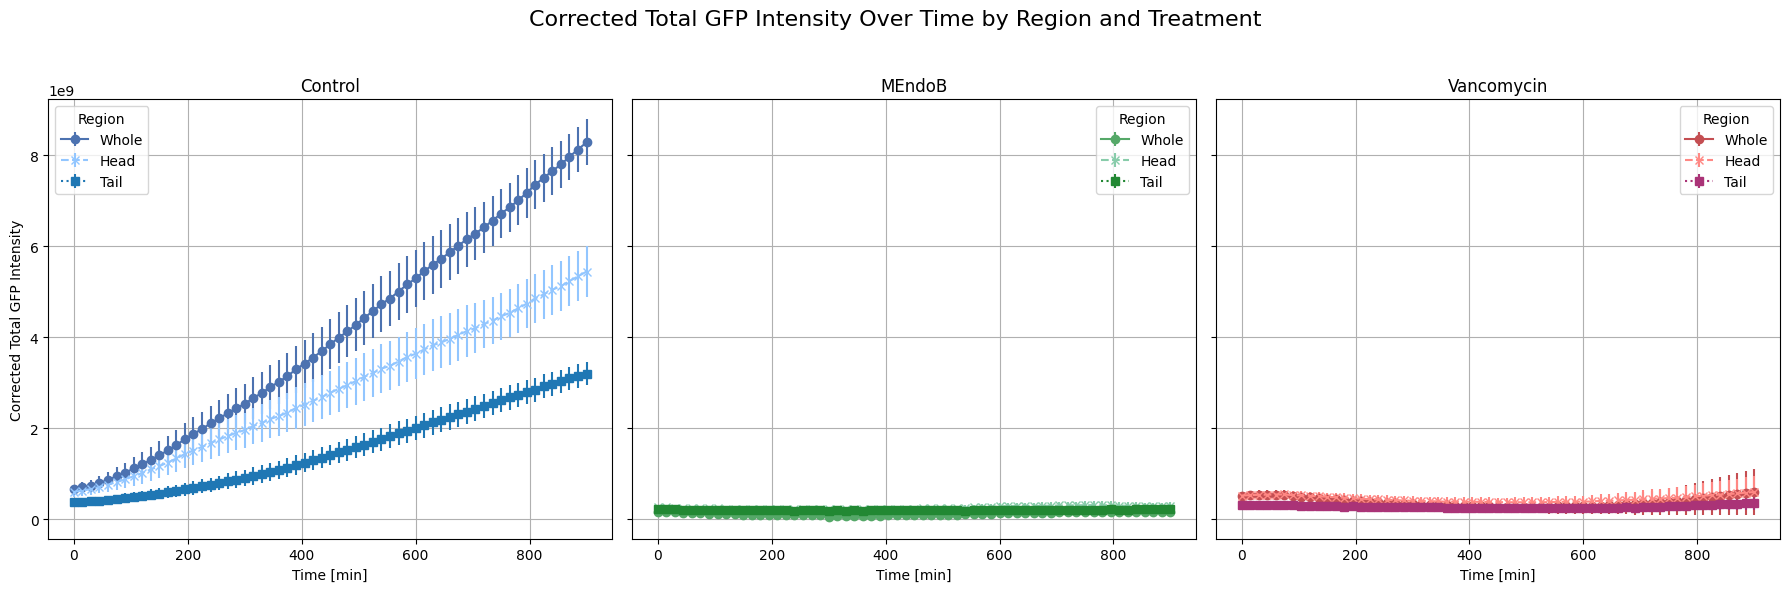

In [31]:
# Exclude identifier that starts with C4
filtered_df = df[~df['Identifier'].str.startswith('C4')]

# Group by Treatment and Time to calculate mean and standard error for the line plot
summary = filtered_df.groupby(['Treatment', 'Time']).agg(
    Whole_Total=('Corrected_Total_GFP_Intensity', 'mean'),
    Whole_SEM=('Corrected_Total_GFP_Intensity', 'sem'),
    Head_Total=('Corrected_Total_Head_Intensity', 'mean'),
    Head_SEM=('Corrected_Total_Head_Intensity', 'sem'),
    Tail_Total=('Corrected_Total_Tail_Intensity', 'mean'),
    Tail_SEM=('Corrected_Total_Tail_Intensity', 'sem'),
).reset_index()

# Generate lineplot for corrected mean GFP intensity by treatment group, excluding identifier that starts with C4
treatments = summary['Treatment'].unique()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)

for ax, treatment in zip(axes, treatments):
    subset = summary[summary['Treatment'] == treatment]
    
    # Plot each region
    ax.errorbar(subset['Time'], subset['Whole_Total'], yerr=subset['Whole_SEM'], 
                label="Whole", linestyle='-', marker='o', color=colors[treatment][0])
    ax.errorbar(subset['Time'], subset['Head_Total'], yerr=subset['Head_SEM'], 
                label="Head", linestyle='--', marker='x', color=colors[treatment][1])
    ax.errorbar(subset['Time'], subset['Tail_Total'], yerr=subset['Tail_SEM'], 
                label="Tail", linestyle=':', marker='s', color=colors[treatment][2])
    
    # Set axis labels, grid, and title
    ax.set_title(treatment)
    ax.set_xlabel("Time [min]")
    ax.grid()
    
    # Add a legend for each subplot
    ax.legend(title="Region")

# Add shared y-axis label
axes[0].set_ylabel("Corrected Total GFP Intensity")

# Add a shared title and adjust layout
fig.suptitle("Corrected Total GFP Intensity Over Time by Region and Treatment", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()